In [1]:
import random

import pandas as pd
import numpy as np
import arviz as az
import pylab as plt
import statsmodels.api as sm

from tqdm import tqdm
from pymc3 import *
from scipy.stats import norm, ttest_ind
from scipy.interpolate import interp1d

import simulate_data.simulate_data as sd
import analysis_code.run_linear_data_analysis as rlda

In [2]:
ITERATIONS = 1000
TUNE = 3000
N_POST_SAMPLES = 50#100
NUMBER_OF_PREDICTORS = 10
RANDOM_SEED = 3#58

N_IN_STUDY = 500

In [3]:
iterations=ITERATIONS
tune=TUNE
n_post_samples=N_POST_SAMPLES
n_predictors=NUMBER_OF_PREDICTORS
n_in_study=N_IN_STUDY
#y_0_1_noise=Y_0_1_NOISE
#log_odds_noise=LOG_ODDS_NOISE
seed=RANDOM_SEED

In [4]:
# Create the Data
linear_data = sd.make_hahn_data(function_type="linear", effect_type="heterogeneous", n_in_study=500)
linear_data.columns

Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'w_i', 'mu', 'Tau', 'pi',
       'x_1_x_3', 'x_2_x_5', 'x_4_1', 'x_4_2', 'x_4_3', 'P(T=1)', 'T',
       'Y0_given_X', 'Y1_given_X', 'Y_obs'],
      dtype='object')

In [5]:
#print(true_beta_propensity_scores)
print(sum(linear_data['T'])/linear_data.shape[0])
#Initialize Analysis Object
predictors=preds=['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5','x_1_x_3', 'x_2_x_5', 'x_4_2', 'x_4_3',]

lm_preds = ['x_0','x_1_x_3', 'x_2_x_5', 'x_4_2', 'x_4_3']
prop_score_preds=['x_0','x_1','x_1_x_3', 'x_2_x_5', 'x_4_2', 'x_4_3']

0.738


In [6]:
analysis_obj = rlda.linear_model_analysis(
    data=linear_data, 
    true_beta_propensity_score=np.zeros(len(preds)), 
    true_beta_response=np.zeros(len(preds)), 
    predictors=preds
)

In [7]:
## Fit Propensity Model
analysis_obj.fit_propensity_score_model(niter=iterations, tune=tune, progressbar_bool=True,predictors=prop_score_preds)
## Get Posterior of Propensity Model
ps_post_pred = analysis_obj.get_posterior_predictive(
    model_in=analysis_obj.propensity_score_model, 
    trace_in = analysis_obj.propensity_score_trace,
    var_names_in = ['propensity_score'],
)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Beta]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 26 seconds.


/Users/omarchavez/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


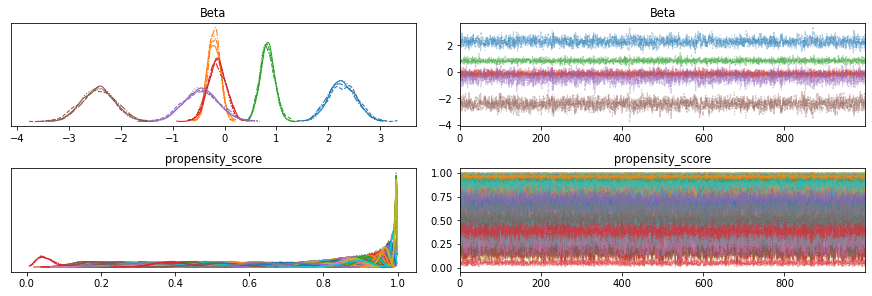

In [8]:
_=traceplot(analysis_obj.propensity_score_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, Beta]
Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 28 seconds.
/Users/omarchavez/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


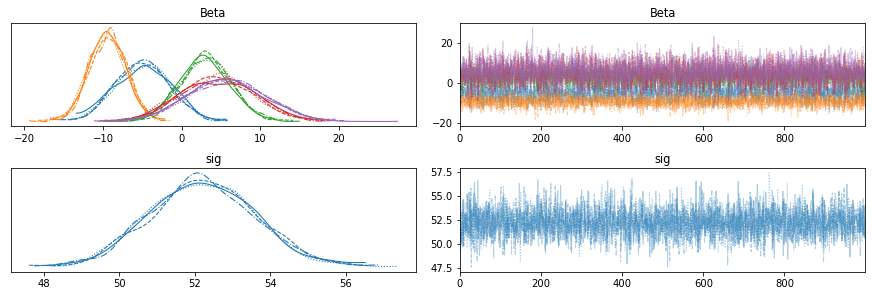

In [9]:
# Fit Y_I_star Model with Mean Propensity Score
Y_i_star_mean_propensity_linear_model_model, Y_i_star_mean_propensity_linear_model_trace = (
    analysis_obj.fit_Y_i_star_mean_propensity_linear_model(niter=iterations, tune=tune, predictors=lm_preds))
_=traceplot(analysis_obj.Y_i_star_mean_propensity_linear_model_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, Beta]
Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 24 seconds.
/Users/omarchavez/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


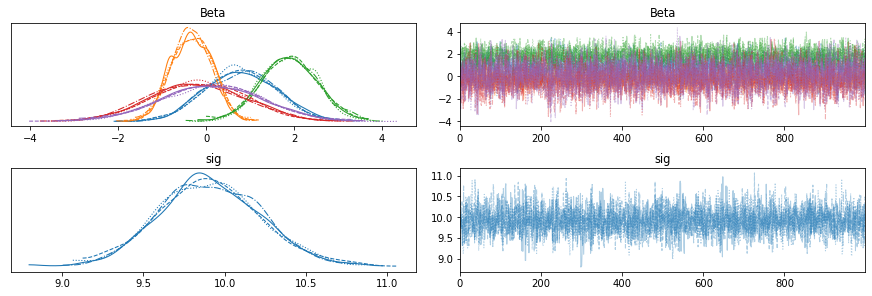

In [10]:
# Fit Y_I_star Model with True Propensity Score
Y_i_star_true_propensity_linear_model_model, Y_i_star_true_propensity_linear_model_trace =(
    analysis_obj.fit_Y_i_star_true_propensity_linear_model(niter=iterations, tune=tune, predictors=lm_preds))
_=traceplot(analysis_obj.Y_i_star_true_propensity_linear_model_trace)

In [11]:
# Fit Y_i_star Model with Posterior Based Propensity Scores
analysis_obj.fit_Y_i_star_posterior_based_model(
    niter=iterations, tune=tune, n_post_samples=n_post_samples,predictors=lm_preds)


100%|██████████| 50/50 [33:07<00:00, 39.76s/it]


Text(0.5, 0, 'True P(T=1)')

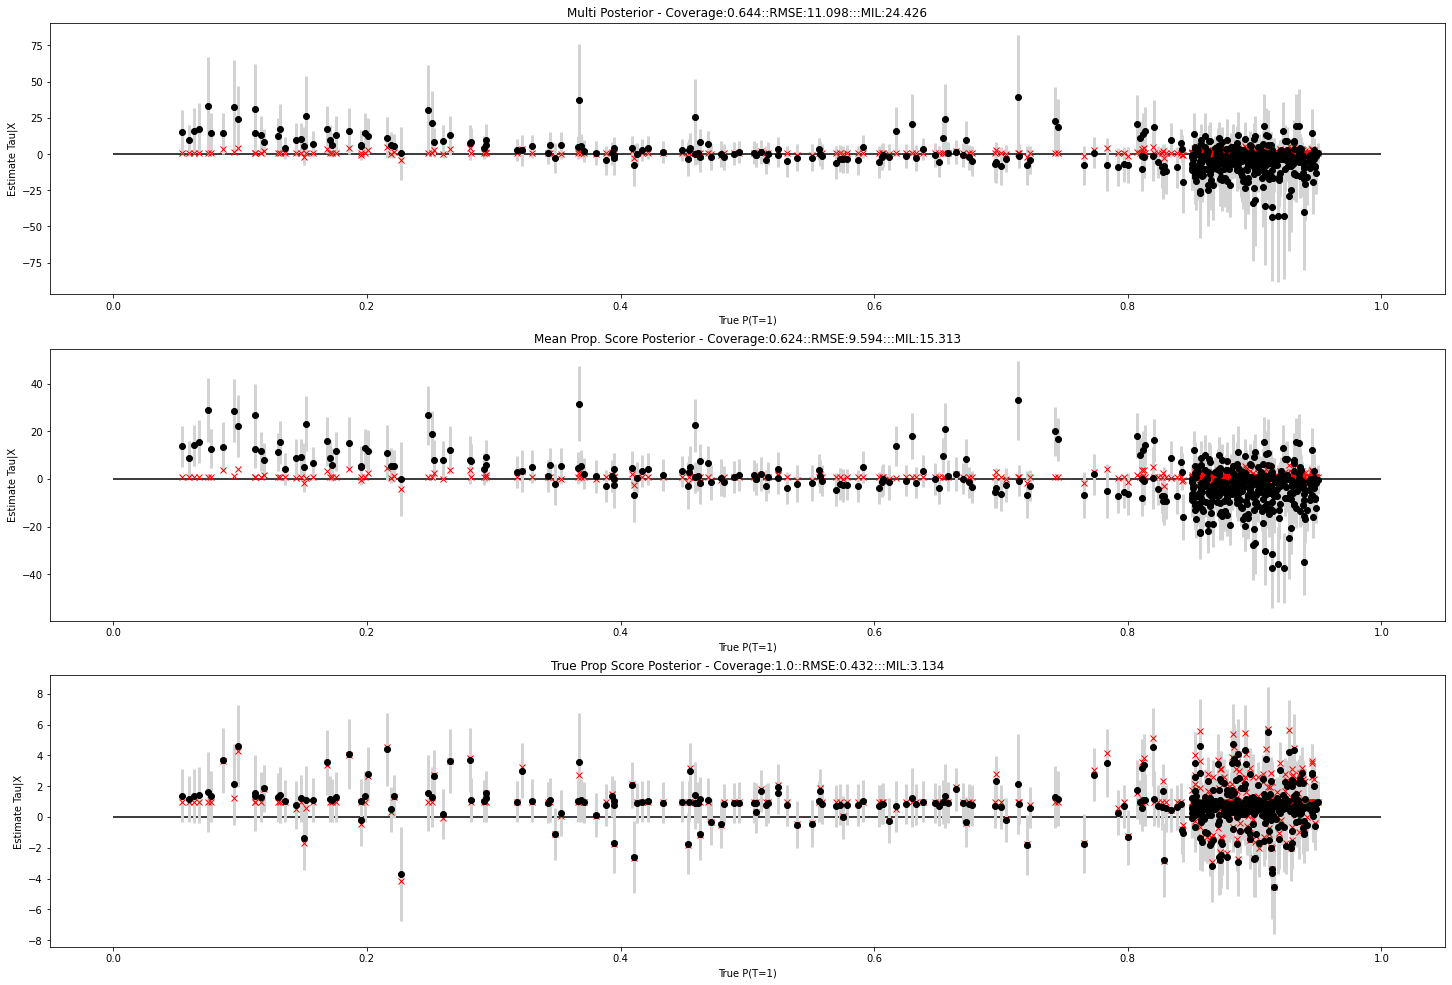

In [18]:
sub_N = n_in_study-1
X=analysis_obj.data[lm_preds]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)

plt.figure(figsize=(25,17))
## PLOT 1
plt.subplot(3, 1, 1)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
temp_fp = fp_Tau.loc[:, :sub_N]
x=analysis_obj.data.loc[:,'P(T=1)']
y=fp_Tau.mean(axis=0)
interval_high = np.quantile(fp_Tau, q=0.95, axis=0)
interval_low = np.quantile(fp_Tau, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x", color='red')
mp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
mp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_mp = 1-(sum(mp_max_violation)+sum(mp_min_violation))/len(mp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
emp = fp_Tau.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(emp*emp)), 3))    
_=plt.title("Multi Posterior - Coverage:" + str(coverage_mp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True P(T=1)')

## PLOT 2
plt.subplot(3, 1, 2)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=lm_preds))
x=analysis_obj.data.loc[:,'P(T=1)']
y=post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x", color='red')
sp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
sp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_sp = 1-(sum(sp_max_violation)+sum(sp_min_violation))/len(sp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
esp = post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(esp*esp)), 3))    
_=plt.title("Mean Prop. Score Posterior - Coverage:" + str(coverage_sp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True P(T=1)')

## PLOT 3
plt.subplot(3, 1, 3)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_true_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_true_propensity_linear_model_model, 
    trace_in=Y_i_star_true_propensity_linear_model_trace, 
    predictors=lm_preds))
x=analysis_obj.data.loc[:,'P(T=1)']
y=post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x", color='red')
tp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
tp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_tp = 1-(sum(tp_max_violation)+sum(tp_min_violation))/len(tp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
etp = post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(etp*etp)), 3))    
_=plt.title("True Prop Score Posterior - Coverage:" + str(coverage_tp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True P(T=1)')


### Estimated Tau|X vs True Tau|X with 90% Cred. Intevals

Text(0.5, 0, 'True Tau')

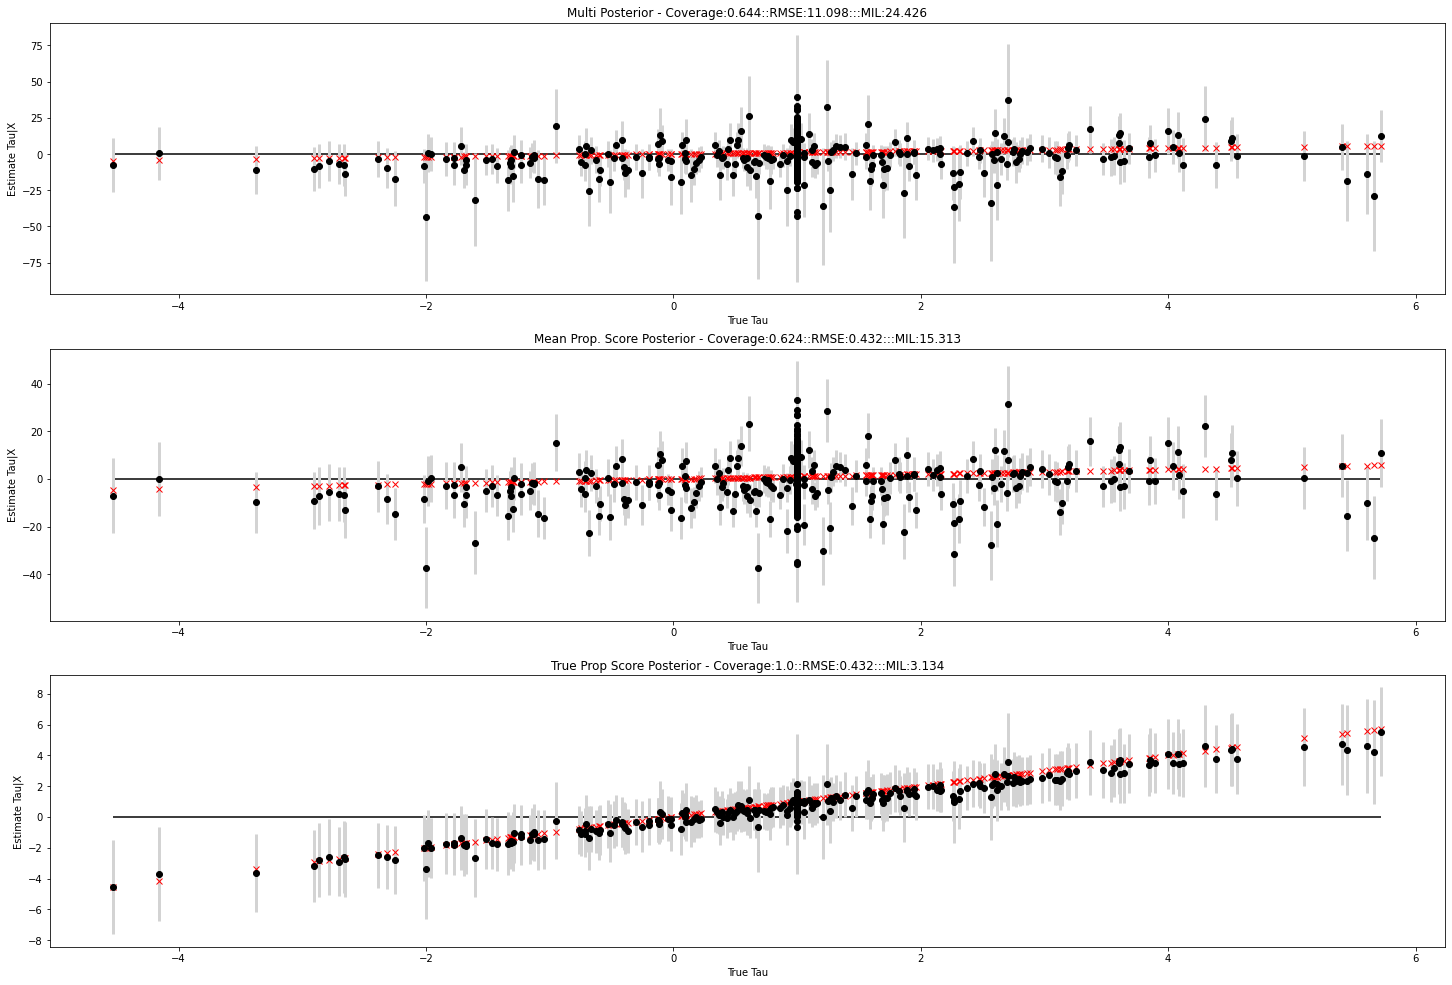

In [20]:
sub_N = n_in_study-1
X=analysis_obj.data[lm_preds]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)

plt.figure(figsize=(25,17))
## PLOT 1
plt.subplot(3, 1, 1)
plt.hlines(
    0, xmin=min(analysis_obj.data.loc[:,'Tau']), 
    xmax=max(analysis_obj.data.loc[:,'Tau'])
    , colors='k', linestyles='solid')
temp_fp = fp_Tau.loc[:, :sub_N]
x=analysis_obj.data.loc[:,'Tau']
y=fp_Tau.mean(axis=0)
interval_high = np.quantile(fp_Tau, q=0.95, axis=0)
interval_low = np.quantile(fp_Tau, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x", color='red')
mp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
mp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_mp = 1-(sum(mp_max_violation)+sum(mp_min_violation))/len(mp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
emp = fp_Tau.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(emp*emp)), 3))    
_=plt.title("Multi Posterior - Coverage:" + str(coverage_mp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True Tau')

## PLOT 2
plt.subplot(3, 1, 2)
plt.hlines(
    0, xmin=min(analysis_obj.data.loc[:,'Tau']), 
    xmax=max(analysis_obj.data.loc[:,'Tau'])
    , colors='k', linestyles='solid')
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=lm_preds))
x=analysis_obj.data.loc[:,'Tau']
y=post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x",color='red')
sp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
sp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_sp = 1-(sum(sp_max_violation)+sum(sp_min_violation))/len(sp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
esp = post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(esp*esp)), 3))    
_=plt.title("Mean Prop. Score Posterior - Coverage:" + str(coverage_sp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True Tau')

## PLOT 3
plt.subplot(3, 1, 3)
plt.hlines(
    0, xmin=min(analysis_obj.data.loc[:,'Tau']), 
    xmax=max(analysis_obj.data.loc[:,'Tau'])
    , colors='k', linestyles='solid')
post_mean_Y_i_star_true_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_true_propensity_linear_model_model, 
    trace_in=Y_i_star_true_propensity_linear_model_trace, 
    predictors=lm_preds))
x=analysis_obj.data.loc[:,'Tau']
y=post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x",color='red')
tp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
tp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_tp = 1-(sum(tp_max_violation)+sum(tp_min_violation))/len(tp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
etp = post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(etp*etp)), 3))    
_=plt.title("True Prop Score Posterior - Coverage:" + str(coverage_tp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True Tau')

### Estimated Tau|X (with 90% CI) vs p-hat (Estimated P(T=1) )

Text(0.5, 0, 'True P(T=1)')

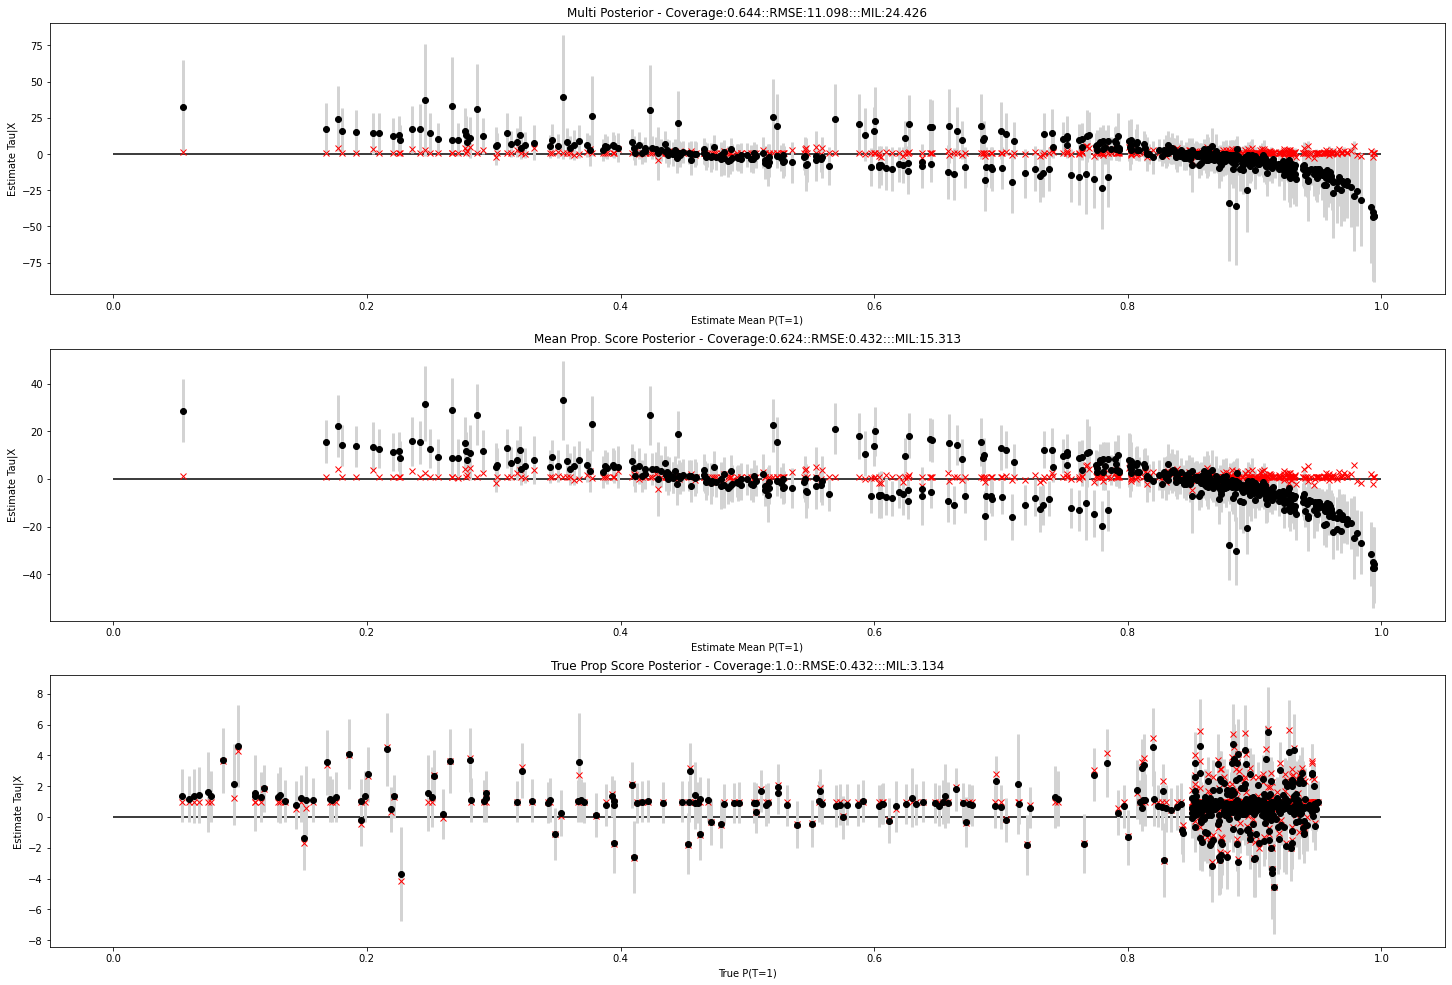

In [21]:
sub_N = n_in_study-1
X=analysis_obj.data[lm_preds]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)

plt.figure(figsize=(25,17))
## PLOT 1
plt.subplot(3, 1, 1)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
temp_fp = fp_Tau.loc[:, :sub_N]
#x=analysis_obj.data.loc[:,'Tau']
x=analysis_obj.propensity_score_trace["propensity_score"].mean(axis=0)
y=fp_Tau.mean(axis=0)
interval_high = np.quantile(fp_Tau, q=0.95, axis=0)
interval_low = np.quantile(fp_Tau, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x", color='red')
mp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
mp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_mp = 1-(sum(mp_max_violation)+sum(mp_min_violation))/len(mp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
emp = fp_Tau.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(emp*emp)), 3))    
_=plt.title("Multi Posterior - Coverage:" + str(coverage_mp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('Estimate Mean P(T=1)')

## PLOT 2
plt.subplot(3, 1, 2)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=lm_preds))
#x=analysis_obj.data.loc[:,'Tau']
x=y=analysis_obj.propensity_score_trace["propensity_score"].mean(axis=0)
y=post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x",color='red')
sp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
sp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_sp = 1-(sum(sp_max_violation)+sum(sp_min_violation))/len(sp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
esp = post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(esp*esp)), 3))    
_=plt.title("Mean Prop. Score Posterior - Coverage:" + str(coverage_sp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('Estimate Mean P(T=1)')

## PLOT 3
plt.subplot(3, 1, 3)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_true_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_true_propensity_linear_model_model, 
    trace_in=Y_i_star_true_propensity_linear_model_trace, 
    predictors=lm_preds))
x=analysis_obj.data.loc[:,'P(T=1)']
y=post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
_=plt.plot(x, analysis_obj.data.loc[:,'Tau'], "x",color='red')
tp_max_violation = interval_high < analysis_obj.data.loc[:, 'Tau']
tp_min_violation = interval_low > analysis_obj.data.loc[:, 'Tau']
coverage_tp = 1-(sum(tp_max_violation)+sum(tp_min_violation))/len(tp_min_violation)
mil = str(round(np.mean(interval_high - interval_low),3))
etp = post_mean_Y_i_star_true_propensity_linear_model_trace.mean(axis=0) - analysis_obj.data.loc[:, 'Tau']
rmse = str(round(np.sqrt(np.mean(etp*etp)), 3))    
_=plt.title("True Prop Score Posterior - Coverage:" + str(coverage_tp)+ "::RMSE:"+ rmse + ":::MIL:" + mil )
plt.ylabel('Estimate Tau|X')
plt.xlabel('True P(T=1)')

### Credible Interval Length vs True P(T=1)

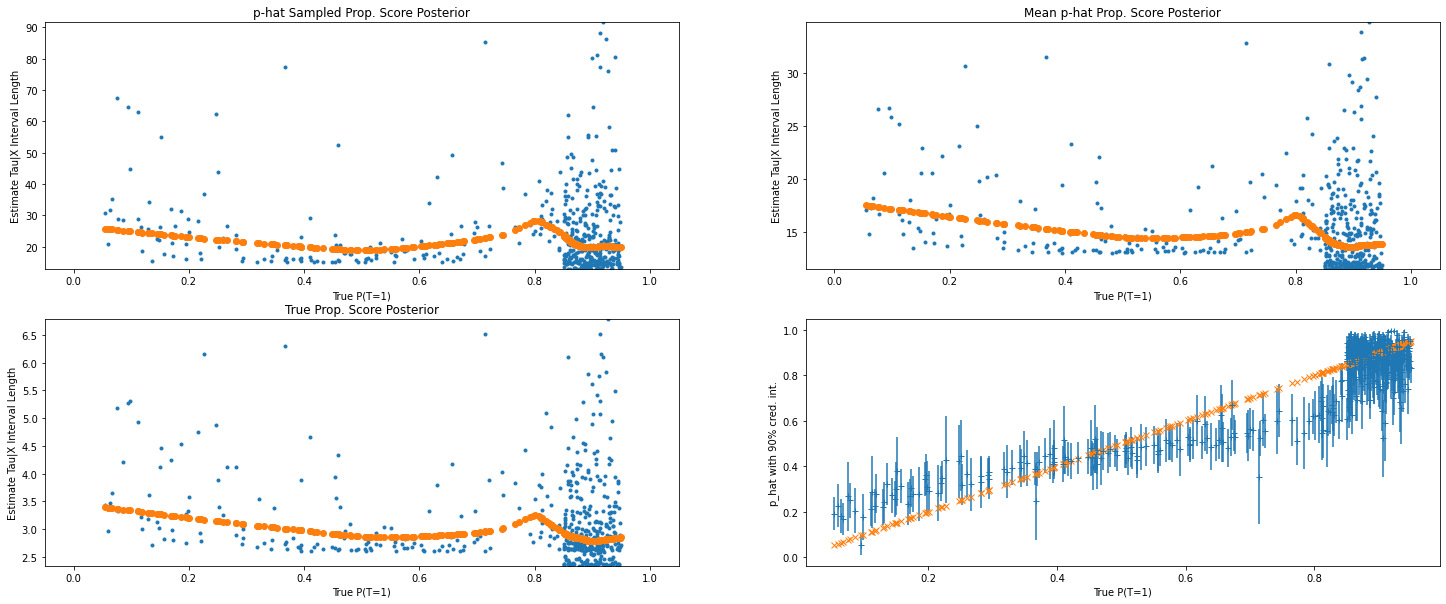

In [23]:
#plt.subplot(3, 3, 3)
#x=analysis_obj.data.loc[:,'P(T=1)']
#y=interval_high - interval_low
#lowess = sm.nonparametric.lowess(y, x, frac=.5)
#lowess_x = list(zip(*lowess))[0]
#lowess_y = list(zip(*lowess))[1]
#f = interp1d(lowess_x, lowess_y, bounds_error=False)
#ynew = f(x)
#plt.plot(x, y, '.')
#plt.plot(x, ynew, 'o')
#plt.ylabel('Interval Length')
#plt.xlabel('True P(T=1)')
sub_N = n_in_study-1
X=analysis_obj.data[lm_preds]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)

plt.figure(figsize=(25,10))
## PLOT 1
plt.subplot(2, 2, 1)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
temp_fp = fp_Tau.loc[:, :sub_N]
x=x=analysis_obj.data.loc[:,'P(T=1)']
interval_high = np.quantile(fp_Tau, q=0.95, axis=0)
interval_low = np.quantile(fp_Tau, q=0.05, axis=0)
y=interval_high-interval_low
lowess = sm.nonparametric.lowess(y, x, frac=.5)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
ynew = f(x)
plt.plot(x, y, '.')
plt.plot(x, ynew, 'o')
plt.ylim((min(y),max(y)))
_=plt.title("p-hat Sampled Prop. Score Posterior")
plt.ylabel('Estimate Tau|X Interval Length')
plt.xlabel('True P(T=1)')

## PLOT 2
plt.subplot(2, 2, 2)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=lm_preds))
x=x=analysis_obj.data.loc[:,'P(T=1)']
y=post_mean_Y_i_star_mean_propensity_linear_model_trace.mean(axis=0)
interval_high = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_mean_propensity_linear_model_trace, q=0.05, axis=0)
y=interval_high-interval_low
lowess = sm.nonparametric.lowess(y, x, frac=.5)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
ynew = f(x)
plt.plot(x, y, '.')
plt.plot(x, ynew, 'o')
plt.ylim((min(y),max(y)))
_=plt.title("Mean p-hat Prop. Score Posterior")
plt.ylabel('Estimate Tau|X Interval Length')
plt.xlabel('True P(T=1)')

## PLOT 3
plt.subplot(2, 2, 3)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
post_mean_Y_i_star_true_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_true_propensity_linear_model_model, 
    trace_in=Y_i_star_true_propensity_linear_model_trace, 
    predictors=lm_preds))
x=x=analysis_obj.data.loc[:,'P(T=1)']
interval_high = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.95, axis=0)
interval_low = np.quantile(post_mean_Y_i_star_true_propensity_linear_model_trace, q=0.05, axis=0)
y=interval_high-interval_low
lowess = sm.nonparametric.lowess(y, x, frac=.5)
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]
f = interp1d(lowess_x, lowess_y, bounds_error=False)
ynew = f(x)
plt.plot(x, y, '.')
plt.plot(x, ynew, 'o')
plt.ylim((min(y),max(y)))
_=plt.title("True Prop. Score Posterior")
plt.ylabel('Estimate Tau|X Interval Length')
plt.xlabel('True P(T=1)')

# Plot 4
plt.subplot(2, 2, 4)
x=analysis_obj.data.loc[:,'P(T=1)']
y=analysis_obj.propensity_score_trace["propensity_score"].mean(axis=0)
interval_high = np.quantile(analysis_obj.propensity_score_trace["propensity_score"], q=0.95, axis=0)
interval_low = np.quantile(analysis_obj.propensity_score_trace["propensity_score"], q=0.05, axis=0)
y_error= (interval_high - interval_low)/2
_=plt.errorbar(x, y, yerr=y_error, fmt="+")
_=plt.plot(x, x, "x")
plt.ylabel('p_hat with 90% cred. int.')
plt.xlabel('True P(T=1)')
plt.show()

### Tau-hat posterior Variance for p-hat sampled prop score vs Tau-hat posterior Variance for mean p-hat  prop score

Text(0.5, 0, 'Estimate Tau|X Varinace (mean p-hat)')

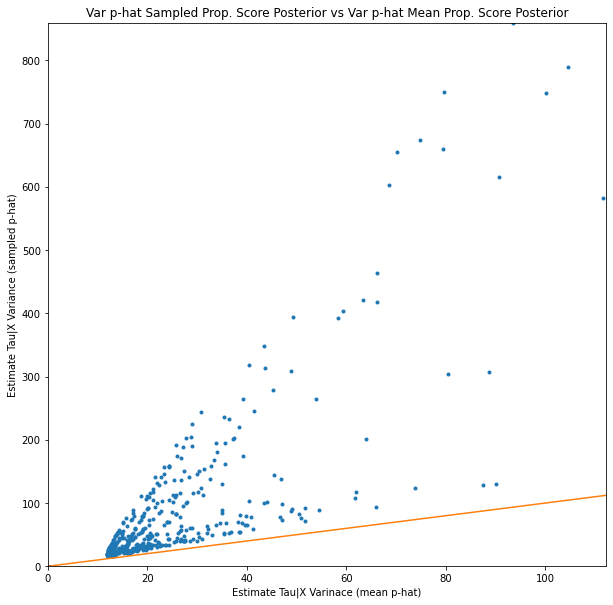

In [24]:
sub_N = n_in_study-1
X=analysis_obj.data[lm_preds]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=lm_preds))

plt.figure(figsize=(10,10))
## PLOT 1
#plt.subplot(2, 2, 1)
plt.hlines(0, xmin=0, xmax=1, colors='k', linestyles='solid')
temp_fp = fp_Tau.loc[:, :sub_N]
x=post_mean_Y_i_star_mean_propensity_linear_model_trace.var(axis=0)
y=np.var(temp_fp, axis=0)
#lowess = sm.nonparametric.lowess(y, x, frac=.5)
#lowess_x = list(zip(*lowess))[0]
#lowess_y = list(zip(*lowess))[1]
#f = interp1d(lowess_x, lowess_y, bounds_error=False)
#ynew = f(x)
plt.plot(x, y, '.')
#plt.plot(x, ynew, 'o')
plt.plot([0,max([max(y),max(x)])],[0,max([max(y),max(x)])])
plt.ylim((0,max(y)+1))#((min(y),max(y)))
plt.xlim((0,max(x)+.5))#((min(y),max(y)))

_=plt.title("Var p-hat Sampled Prop. Score Posterior vs Var p-hat Mean Prop. Score Posterior")
plt.ylabel('Estimate Tau|X Variance (sampled p-hat)')
plt.xlabel('Estimate Tau|X Varinace (mean p-hat)')

In [25]:
ps = analysis_obj.data.loc[:,'P(T=1)']
quantiles = np.quantile(ps, q=[.1,.2,.3,.4,.5,.6,.7,.8,.9])

Text(0.5, 0, 'T to proportion bucketed by deciles')

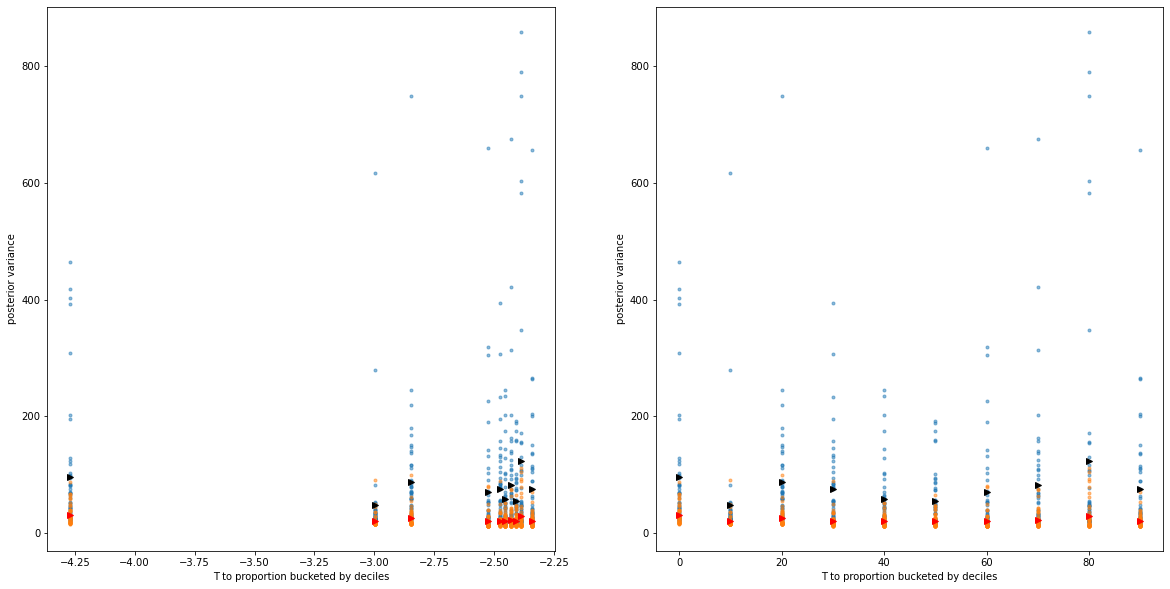

In [27]:
idx_0_10 = np.logical_and(ps>=0, ps<quantiles[0])
idx_10_20 = np.logical_and(ps>=quantiles[0], ps<quantiles[1])
idx_20_30 = np.logical_and(ps>=quantiles[1], ps<quantiles[2])
idx_30_40 = np.logical_and(ps>=quantiles[2], ps<quantiles[3])
idx_40_50 = np.logical_and(ps>=quantiles[3], ps<quantiles[4])
idx_50_60 = np.logical_and(ps>=quantiles[4], ps<quantiles[5])
idx_60_70 = np.logical_and(ps>=quantiles[5], ps<quantiles[6])
idx_70_80 = np.logical_and(ps>=quantiles[6], ps<quantiles[7])
idx_80_90 = np.logical_and(ps>=quantiles[7], ps<quantiles[8])
idx_90_100 = np.logical_and(ps>=quantiles[8], ps<1)

T_C_proportion = np.zeros(analysis_obj.data.shape[0])
T_C_proportion[idx_0_10] = sum(analysis_obj.data.loc[idx_0_10,'T'])/analysis_obj.data.shape[0]
T_C_proportion[idx_10_20] = sum(analysis_obj.data.loc[idx_10_20,'T'])/analysis_obj.data.shape[0]
T_C_proportion[idx_20_30] = sum(analysis_obj.data.loc[idx_20_30,'T'])/analysis_obj.data.shape[0]
T_C_proportion[idx_30_40] = sum(analysis_obj.data.loc[idx_30_40,'T'])/analysis_obj.data.shape[0]
T_C_proportion[idx_40_50] = sum(analysis_obj.data.loc[idx_40_50,'T'])/analysis_obj.data.shape[0]
T_C_proportion[idx_50_60] = sum(analysis_obj.data.loc[idx_50_60,'T'])/analysis_obj.data.shape[0]
T_C_proportion[idx_60_70] = sum(analysis_obj.data.loc[idx_60_70,'T'])/analysis_obj.data.shape[0]
T_C_proportion[idx_70_80] = sum(analysis_obj.data.loc[idx_70_80,'T'])/analysis_obj.data.shape[0]
T_C_proportion[idx_80_90] = sum(analysis_obj.data.loc[idx_80_90,'T'])/analysis_obj.data.shape[0]
T_C_proportion[idx_90_100] = sum(analysis_obj.data.loc[idx_90_100,'T'])/analysis_obj.data.shape[0]

T_C_proportion_label=np.zeros(analysis_obj.data.shape[0])
T_C_proportion_label[idx_0_10] = 0
T_C_proportion_label[idx_10_20]  = 10
T_C_proportion_label[idx_20_30]  = 20
T_C_proportion_label[idx_30_40]  = 30
T_C_proportion_label[idx_40_50]  = 40
T_C_proportion_label[idx_50_60]  = 50
T_C_proportion_label[idx_60_70]  = 60
T_C_proportion_label[idx_70_80]  = 70
T_C_proportion_label[idx_80_90]  = 80
T_C_proportion_label[idx_90_100] = 90

sub_N = n_in_study-1
X=analysis_obj.data[lm_preds]
posterir_fp_Tau = np.matmul(
    X.to_numpy(), 
    analysis_obj.Y_i_star_posterior_propensity_linear_model_trace.to_numpy().T)
fp_Tau = pd.DataFrame(posterir_fp_Tau.T)
post_mean_Y_i_star_mean_propensity_linear_model_trace = pd.DataFrame(analysis_obj.get_posterior_mean(
    model_in=Y_i_star_mean_propensity_linear_model_model, 
    trace_in=Y_i_star_mean_propensity_linear_model_trace, 
    predictors=lm_preds))

plt.figure(figsize=(20,10))
## PLOT 1
plt.subplot(1, 2, 1)
plt.plot(np.log(T_C_proportion), fp_Tau.var(axis=0), '.', alpha=.5)
plt.plot(np.log(T_C_proportion), post_mean_Y_i_star_mean_propensity_linear_model_trace.var(axis=0), '.', alpha=.5)

df = pd.DataFrame(
    {
        'mean_post_mean_variance':post_mean_Y_i_star_mean_propensity_linear_model_trace.var(axis=0),
        'multi_post_mean_variance':fp_Tau.var(axis=0),
        'T_C_proportion':T_C_proportion,
        'T_C_proportion_label': T_C_proportion_label
    }
)


plt.plot(
    np.log(df.groupby('T_C_proportion_label').mean().T_C_proportion), 
    df.groupby('T_C_proportion_label').mean().multi_post_mean_variance,
    '>', color='black')
plt.plot(
    np.log(df.groupby('T_C_proportion_label').mean().T_C_proportion), 
    df.groupby('T_C_proportion_label').mean().mean_post_mean_variance,
    '>', color='red')
plt.ylabel('posterior variance')
plt.xlabel('T to proportion bucketed by deciles')

## PLOT 2
plt.subplot(1, 2, 2)
plt.plot((T_C_proportion_label), fp_Tau.var(axis=0), '.', alpha=.5)
plt.plot((T_C_proportion_label), post_mean_Y_i_star_mean_propensity_linear_model_trace.var(axis=0), '.', alpha=.5)
plt.plot(
    df.groupby('T_C_proportion_label').mean().index.values, 
    df.groupby('T_C_proportion_label').mean().multi_post_mean_variance,
    '>', color='black')
plt.plot(
    df.groupby('T_C_proportion_label').mean().index.values, 
    df.groupby('T_C_proportion_label').mean().mean_post_mean_variance,
    '>', color='red')
plt.ylabel('posterior variance')
plt.xlabel('T to proportion bucketed by deciles')

(-10.0, 20.0)

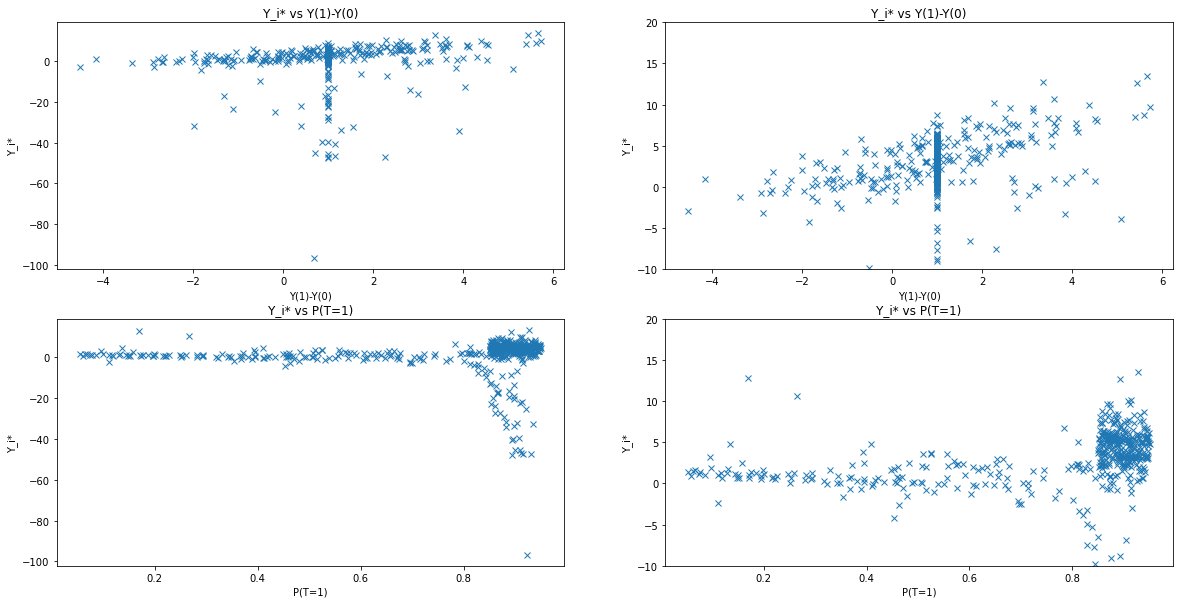

In [34]:
x=analysis_obj.data.loc[:,'Tau']
y=rlda.get_Y_i_star(
    Y_obs=analysis_obj.data.loc[:,'Y_obs'],
    W_i=analysis_obj.data.loc[:,'T'], 
    p=analysis_obj.data.loc[:,'P(T=1)'],
)
plt.figure(figsize=(20,10))

plt.subplot(2, 2, 1)
plt.plot(x, y, 'x')
plt.title("Y_i* vs Y(1)-Y(0)")
plt.ylabel('Y_i*')
plt.xlabel('Y(1)-Y(0)')

plt.subplot(2, 2, 2)
plt.plot(x, y, 'x')
plt.title("Y_i* vs Y(1)-Y(0)")
plt.ylabel('Y_i*')
plt.xlabel('Y(1)-Y(0)')
plt.ylim(-10,20)

plt.subplot(2, 2, 3)
x=analysis_obj.data.loc[:,'P(T=1)']
plt.plot(x, y, 'x')
plt.title("Y_i* vs P(T=1)")
plt.ylabel('Y_i*')
plt.xlabel('P(T=1)')

plt.subplot(2, 2, 4)
x=analysis_obj.data.loc[:,'P(T=1)']
plt.plot(x, y, 'x')
plt.title("Y_i* vs P(T=1)")
plt.ylabel('Y_i*')
plt.xlabel('P(T=1)')
plt.ylim(-10,20)
